<a href="https://colab.research.google.com/github/Ang3lino/recomenderSys/blob/master/autorec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import os
import random
import pickle

from sortedcontainers import SortedList
from collections import Counter, defaultdict
from tqdm import tqdm  # modulo cuya finalidad es dar un feedback del progreso de algun procedimiento

from sklearn import preprocessing  # LabelEncoder
from sklearn.utils import shuffle
from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz

In [2]:
from google.colab import drive  
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !pip install tqdm --upgrade
# tqdm.pandas()

In [4]:
fdir = "drive/My Drive/petroleo/movielens-20m-dataset"
fname = 'rating.csv'
df = pd.read_csv(os.path.join(fdir, fname))
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [0]:
le = preprocessing.LabelEncoder()
df.loc[:, 'movieId'] = le.fit_transform(df.loc[:, 'movieId'])
le = preprocessing.LabelEncoder()
df.loc[:, 'userId'] = le.fit_transform(df.loc[:, 'userId'])

In [6]:
df.head(1000)

,userId,movieId,rating,timestamp
0,0,1,3.5,2005-04-02 23:53:47
1,0,28,3.5,2005-04-02 23:31:16
2,0,31,3.5,2005-04-02 23:33:39
3,0,46,3.5,2005-04-02 23:32:07
4,0,49,3.5,2005-04-02 23:29:40
...,...,...,...,...
995,10,437,1.5,2009-01-01 23:52:42
996,10,438,4.5,2009-01-01 05:33:22
997,10,476,5.0,2009-01-01 05:45:13
998,10,496,4.5,2009-01-02 01:15:49


In [0]:
df = df.drop(columns=['timestamp'])

In [0]:
m = max(df.loc[:, 'userId']) + 1
n = max(df.loc[:, 'movieId']) + 1

In [0]:
df = shuffle(df)
cutoff = int(0.8 * len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [0]:
matrix = lil_matrix((m, n))
def lil(row):
    global matrix
    i = int(row['userId'])
    j = int(row['movieId'])
    matrix[(i, j)] = row['rating']



In [0]:
def preprocess():
    train_path = os.path.join(fdir, 'matrix_train.npz')
    if not os.path.exists(train_path):
        df_train.progress_apply(lil, axis=1)
        matrix_csr = matrix.tocsr()
        save_npz(train_path, matrix_csr)

    test_path = os.path.join(fdir, 'matrix_train.npz')
    if not os.path.exists(test_path):
        matrix = lil_matrix((m, n))
        df_test.progress_apply(lil, axis=1)
        save_npz(os.path.join(fdir, 'matrix_test.npz'), matrix.tocsr())
    
preprocess()

#Definicion del modelo


In [12]:
import keras.backend as K

from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import SGD

Using TensorFlow backend.


In [0]:
# config
batch_size = 128
epochs = 15
reg = 1e-3

In [0]:
train_matrix = load_npz(os.path.join(fdir, 'matrix_train.npz'))
test_matrix = load_npz(os.path.join(fdir, 'matrix_test.npz'))
train_mask = (train_matrix > 0) * 1.0
test_mask = (test_matrix > 0) * 1.0
m, n = train_matrix.shape
mu = train_matrix.sum() / train_mask.sum()


In [15]:
i = Input(shape=(n,))
x = Dropout(0.7)(i)
x = Dense(1000, activation='tanh', kernel_regularizer=l2(reg))(x)
x = Dense(n, kernel_regularizer=l2(reg))(x)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
def custom_loss(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
    diff = y_pred - y_true
    sqdiff = diff*diff*mask
    sse = K.sum(K.sum(sqdiff))
    n = K.sum(K.sum(mask))
    return sse / n 

def generator(A, M):
    while True:
        A, M = shuffle(A, M)
        for i in range(A.shape[0] // batch_size + 1):
            upper = min((i + 1)*batch_size, A.shape[0])
            a = A[i*batch_size:upper].toarray()
            m = M[i*batch_size:upper].toarray()
            a = a - mu*m
            yield a, a 

def generator_test(A, M, A_test, M_test):
    while True:
        for i in range(A.shape[0] // batch_size + 1):
            upper = min((i + 1)*batch_size, A.shape[0])
            a = A[i*batch_size:upper].toarray()
            m = M[i*batch_size:upper].toarray()
            at = A_test[i*batch_size:upper].toarray()
            mt = M_test[i*batch_size:upper].toarray()
            at = at - mu*mt
            yield a, at

In [17]:
#  new explorer, Jazmin Becerra
model = Model(i, x)
model.compile(
    loss=custom_loss,
    optimizer=SGD(lr=0.08, momentum=0.9),
    metrics=[custom_loss],
) 
print(m, n)


138493 26744


In [18]:
r = model.fit_generator(
    generator(train_matrix, train_mask), 
    validation_data=generator_test(train_matrix, train_mask, test_matrix, test_mask),
    epochs=epochs,
    steps_per_epoch=train_matrix.shape[0] // batch_size + 1,
    validation_steps=train_matrix.shape[0] // batch_size + 1
)






Epoch 1/15





1082/1082 [==============================] - 98s 91ms/step - loss: 1.9181 - custom_loss: 0.7735 - val_loss: 2.3091 - val_custom_loss: 2.1257
Epoch 2/15
1082/1082 [==============================] - 90s 83ms/step - loss: 0.8197 - custom_loss: 0.7207 - val_loss: 2.1583 - val_custom_loss: 2.0889
Epoch 3/15
1082/1082 [==============================] - 89s 83ms/step - loss: 0.7832 - custom_loss: 0.7163 - val_loss: 2.1776 - val_custom_loss: 2.1116
Epoch 4/15
1082/1082 [==============================] - 90s 84ms/step - loss: 0.7812 - custom_loss: 0.7152 - val_loss: 2.1782 - val_custom_loss: 2.1126
Epoch 5/15
1082/1082 [==============================] - 91s 84ms/step - loss: 0.7802 - custom_loss: 0.7146 - val_loss: 2.1134 - val_custom_loss: 2.0491
Epoch 6/15
1082/1082 [==============================] - 93s 86ms/step - loss: 0.7797 - custom_loss: 0.7146 - val_loss: 2.1213 - val_custom_loss: 2.0569
Epoch 7/15
1082/1082 [==============================] - 92s 85ms/step - loss: 0.

In [19]:
print(model.summary())
print(r.history.keys())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26744)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26744)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              26745000  
_________________________________________________________________
dense_2 (Dense)              (None, 26744)             26770744  
Total params: 53,515,744
Trainable params: 53,515,744
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'val_custom_loss', 'loss', 'custom_loss'])


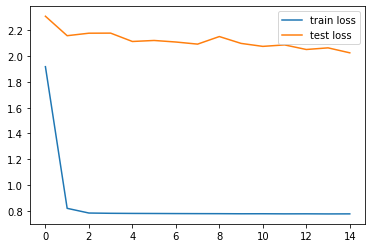

In [20]:
plt.plot(r.history['loss'],  label='train loss')
plt.plot(r.history['val_loss'],  label='test loss')
plt.legend()
plt.show()

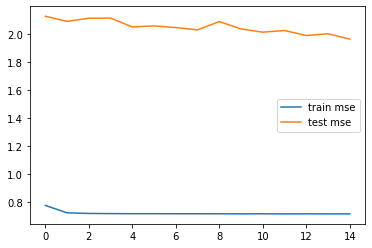

In [21]:
plt.plot(r.history['custom_loss'],  label='train mse')
plt.plot(r.history['val_custom_loss'],  label='test mse')
plt.legend()
plt.show()